In [1]:
import tensorflow as tf # tensorflow dataset (Download the images into tf dataset structure image batch)
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 

import numpy as np
import pandas as pd

2023-03-23 23:47:09.435619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Constant 
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
# EPOCHS = 50 

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory (
    "PlantVillage",
    shuffle=True, # randomly shuffle 
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


There are 20638 files with 15 classes in the dataset.

In [7]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [8]:
len(dataset) # 68, batch of 32 images 

645

In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape) # (32, 256, 256, 1)
    print(label_batch.numpy()) # 0, 1, 2 (Three classes)

(32, 256, 256, 3)
[12 14  5 10 12 14 12  5 10  5  0 11  8  9 11 13  1  1 12  3  9 11  5 11
 12  5 14  1  6 12 14 12]


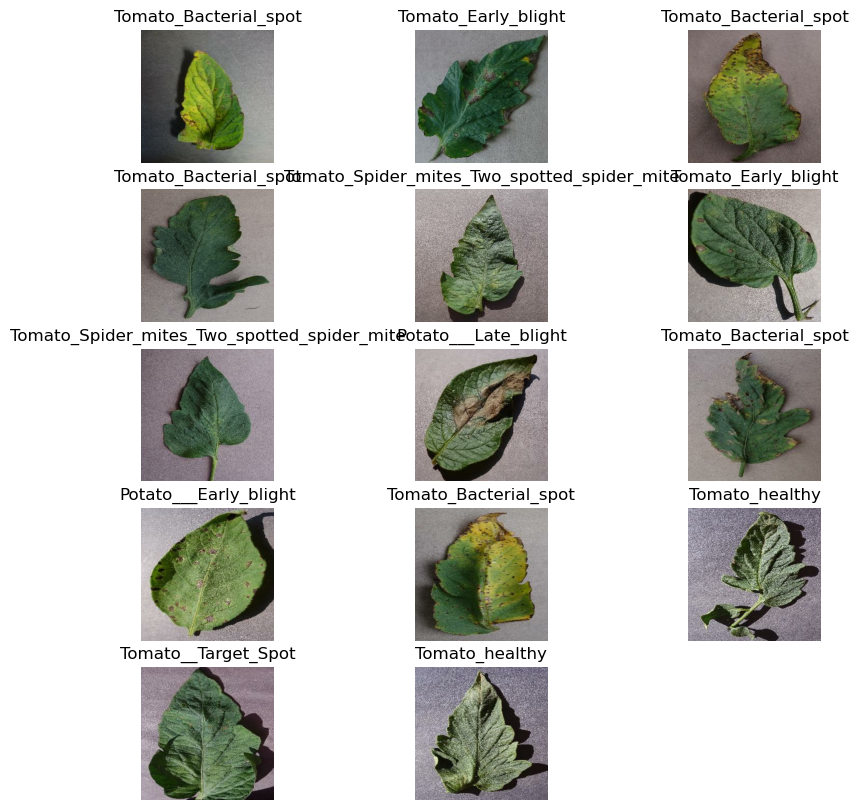

In [18]:
plt.figure(figsize=(10,10))

for image_batch, label_batch in dataset.take(1):
    for i in range(0, 14):
        ax=plt.subplot(5,3,i+1) # print them all at once in one page 
        plt.imshow(image_batch[i].numpy().astype("uint8")) # print first image, converted to int from float
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    # Shuffle = True, thereby the result is different everytime

##### test train data split
80% of training dataset </br>
20% out of training - validation set </br>
20% of test dataset

In [28]:
def test_train_split_tf(ds, train_split=0.8, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size) # train_set 80 % from total 
    val_size = int(val_split * train_size)  # 20 % from 80 % of total(train)
    test_size = int(test_split*ds_size)
    
    train_int = ds.take(train_size)    # first 516 dataset
    val_set = train_int.take(val_size) # first 20% of 80%
    train_set = train_int.skip(val_size).take(train_size-val_size) # remaining 
    test_set = ds.skip(train_size).take(test_size) 
    
    return train_set, val_set, test_set

In [29]:
train_set, val_set, test_set = test_train_split_tf(dataset)

In [34]:
len(train_set) +len(val_set)+len(test_set)

645

In [31]:
len(dataset)

645

##### Cache, Shuffle, and Prefetch the Dataset
When working with large datasets, it is often useful to cache, shuffle, and prefetch the dataset to improve training performance.</br>
</br>
<b>Caching</b> a dataset stores its elements in memory or on disk, so they don't need to be reloaded from disk for each epoch. </br>This can significantly speed up training when the data is read from disk. </br>Caching can be particularly useful when using complex preprocessing steps, as it allows you to perform the preprocessing once and then cache the preprocessed data.</br>
</br>
<b>Shuffling</b> the dataset is important to ensure that the model doesn't overfit to the order of the examples. </br>Randomizing the order of the examples helps ensure that the model sees a representative sample of the data during training.</br>
</br>
<b>Prefetching</b> the dataset allows the model to load data while it is still training on the previous batch. </br>This can help reduce the time it takes to load the data and can help keep the GPU or CPU busy during training.</br>

In [35]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#### Modelling

##### Data preprocessing layers
To increase the efficiency, resize the image and normalize the image pixel values to in range of 0 and 1. (dividing by 256)

In [36]:
# two preprocessing layers for preprocessing the dataset before fitting into the neural network model.
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

##### Data augmentation

In [37]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [38]:
train_set = train_set.map(
    lambda x,y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

##### Model Architecture

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

Plotting the Accuracy and Loss Curves

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
type(history.history['loss'])

In [ ]:
len(history.history['loss'])

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Run prediction on a sample image

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Saving the Model

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

In [ ]:
model.save("../potatoes.h5")